### debug DCC

In [1]:
import os
import sys
import numpy as np
from itertools import combinations

In [16]:
def dynamic_corr(func_file):
    """calculate garch-dcc"""
    sj_mat = np.load(os.path.join(func_file))
    comb = list(combinations(np.arange(sj_mat.shape[1]),2))
    # calculate dcc
    dcc_ls = []
    for c in comb:
        t1 = sj_mat[:,c[0]]
        t2 = sj_mat[:,c[1]]
        dcc_out = calc_dcc(t1, t2)
        dcc_ls.append(dcc_out)
    dcc_sj = np.stack(dcc_ls)
    print(dcc_sj.shape)
    # save correlation
    tmp = func_file.split('/')
    path_name = tmp[:-1]
    file_name = tmp[-1].split('.')[0]
    output_dir = os.path.join(*path_name)
    save_dir = os.path.join(output_dir, 'dynamic_corr')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = file_name+'_dcc.npy'
    output_file = os.path.join(save_dir, file_name)
    np.save(output_file, dcc_sj)
    print(f'dcc output saved to {output_file}')
    return dcc_sj


def calc_dcc(t1, t2):
    """calcualte dcc between 2 time series"""
#     from DCC_GARCH.GARCH import GARCH, garch_loss_gen
    t1_model = GARCH(1,1)
    t1_model.set_loss(garch_loss_gen(1,1))
    t1_model.set_max_itr(1)
    t1_model.fit(t1)
    t1_sigma = t1_model.sigma(t1)
    t1_epsilon = t1/t1_sigma

    t2_model = GARCH(1,1)
    t2_model.set_loss(garch_loss_gen(1,1))
    t2_model.set_max_itr(1)
    t2_model.fit(t2)
    t2_sigma = t2_model.sigma(t2)
    t2_epsilon = t2/t2_sigma    

    epsilon = np.array([t1_epsilon, t2_epsilon])

#     from DCC_GARCH.DCC import DCC, dcc_loss_gen, R_gen
    dcc_model = DCC()
    dcc_model.set_loss(dcc_loss_gen())
    dcc_model.fit(epsilon)

    # get DCC R (conditional correlation matrix)
    ab = dcc_model.get_ab()
    tr = epsilon
    R_ls = R_gen(tr,ab)
    R = np.array(R_ls)
    # flatten Rt
    K = R.shape[1]
    Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
    dcc_out = Rt_triu[0]
    # print(dcc_out.shape)
    # import matplotlib.pyplot as plt
    # plt.plot(dcc_out)
    # plt.savefig('./test.png')
    return dcc_out

In [17]:
from scipy.optimize import minimize
# from DCC_GARCH.DCC.DCC_loss import Q_gen, Q_average

class DCC():

    def __init__(self, max_itr=2, early_stopping=True):
        self.max_itr = max_itr
        self.early_stopping = early_stopping
        self.ab = np.array([0.5, 0.5])
        self.method =  'SLSQP'
        def ub(x):
            return 1. - x[0] - x[1]
        def lb1(x):
            return x[0]
        def lb2(x):
            return x[1]
        self.constraints = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},{'type':'ineq', 'fun':lb2}]

    def set_ab(self,ab): # ndarray
        self.ab = ab

    def get_ab(self):
        return self.ab

    def set_method(self,method):
        self.method = method

    def set_loss(self, loss_func):
        #"loss function L is a meta-function, s.t. L(r) = f(theta)."
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def set_max_itr(self, max_itr):
        self.max_itr = max_itr

    def get_max_itr(self):
        return self.max_itr

    def fit(self, train_data):
        #train_data: numpy.array([[e1_T,...e1_0],\
        #                         [e2_T,...e2_0],\
        #                         ...,
        #                         [en_T,...en_0]])

        tr = train_data

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.get_max_itr():
            j += 1
            ab0 = np.array(self.get_ab())
            res = minimize(self.get_loss_func()(tr), ab0, method=self.method,
                           options={'disp': False},constraints=self.constraints)
            ab = res.x
            self.set_ab(ab)

            tr_loss = self.get_loss_func()(tr)(ab)
            tr_losses.append(tr_loss)
            print("Iteration: %d. Training loss: %.3E." % (j, tr_loss))

            # Early stopping
            if self.early_stopping is True:
                if j > 10:
                    if abs(tr_losses[-1] - tr_losses[-2]) / tr_losses[-2] < 0.0001:
                        count += 1
                        if count >= 2:
                            print("Early Stopping...")
                            return tr_losses

        return tr_losses


    def Q(self,y):
        Q = Q_gen(y,self.ab)
        return Q

    def Q_bar(self,y):
        return Q_average(y)



def Q_average(tr):
    # return average of outer product of [eT,...e0]
    # et = [r(1t)/s(1t),...r(nt)/s(nt)]
    T = tr.shape[1]
    n = tr.shape[0]
    sum = np.zeros([n,n])
    for i in range(T):
        sum += np.outer(tr[:,i],tr[:,i])
    return sum/T

def Q_gen(tr,ab):
    # generate [QT,...Q0]
    Q_int = Q_average(tr)
    Q_list = [Q_int]
    T = tr.shape[1] - 1
    a = ab[0]
    b = ab[1]
    for i in range(T):
        et_1 = tr[:,T-i]
        Qt_1 = Q_list[0]
        Qt = (1.0-a-b)*Q_int + a*np.outer(et_1,et_1) + b*Qt_1
        Q_list = [Qt] + Q_list
    return Q_list

def R_gen(tr,ab):
    Q = Q_gen(tr,ab)
    # output [RT,...R0]
    R_list = []
    n = Q[0].shape[0]
    for i in Q:
        temp = 1.0/np.sqrt(np.abs(i))
        temp = temp * np.eye(n)
        R = np.dot(np.dot(temp,i),temp)
        R_list = R_list + [R]
    return R_list

def dcc_loss(tr, ab):
    R = R_gen(tr,ab)

    def dcc_loss_helper(tr=tr,R=R):
        loss = 0.0
        for i in range(len(R)):
            Ri = R[i]
            Ri_ = np.linalg.inv(Ri)
            ei = tr[:,i]
            loss += np.log(np.linalg.det(Ri)) + np.dot(np.dot(ei,Ri_),ei)
        # print('training loss %f' % loss)
        return loss

    return dcc_loss_helper()


def dcc_loss_gen():
    def loss1(tr):
        def loss(ab):
            return dcc_loss(tr, ab)
        return loss
    return loss1

In [99]:

class GARCH():

    def __init__(self, p=1, q=1, max_itr=3, early_stopping=True):
        # p the lag of r_t, q the lag of s_t
        self.p = p
        self.q = q
        theta0 = [0.005] + [0.1 for i in range(p)] + [0.1 for i in range(p)] + [0.85 for i in range(q)]
        self.theta = np.array(theta0)
        self.max_itr = max_itr
        self.early_stopping = early_stopping
        def ub(x):
            return 1. - x[1] - 0.5*x[2] - x[3]
        def lb1(x):
            return x[1] + x[2]
        def lb2(x):
            return x[0]
        def lb3(x):
            return x[1]
        def lb4(x):
            return x[3]
        self.constraints = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},
                            {'type':'ineq', 'fun':lb2},{'type':'ineq', 'fun':lb3},
                            {'type':'ineq', 'fun':lb4}]
        self.method = 'COBYLA'

    def set_theta(self, theta):
        self.theta = np.array(theta)

    def get_theta(self):
        return self.theta

    def get_p(self):
        return self.p

    def get_q(self):
        return self.q

    def set_loss(self, loss_func):
        "loss function L is a meta-function, s.t. L(r) = f(theta)."
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def set_max_itr(self, max_itr):
        self.max_itr = max_itr

    def get_max_itr(self):
        return self.max_itr

    def set_method(self, method):
        self.method = method

    def get_method(self):
        return self.method

    def fit(self, train_data):  # train_data: [rT,...r0]
        tr = train_data

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.get_max_itr():
            j += 1
            theta0 = self.get_theta()
            res = minimize(self.get_loss_func()(tr), theta0, method=self.method,
                           options={'disp': False}, constraints=self.constraints)
            theta = res.x
            self.set_theta(theta)

            tr_loss = self.get_loss_func()(tr)(theta)
            tr_losses.append(tr_loss)
#             print("Iteration: %d. Training loss: %.3E." % (j, tr_loss))

            # Early stopping
            if self.early_stopping is True:
                if j > 10:
                    if abs(tr_losses[-1] - tr_losses[-2]) / tr_losses[-2] < 0.0001:
                        count += 1
                        if count >= 2:
                            print("Early Stopping...")
                            return tr_losses
        return tr_losses

    def sigma(self, y):  # test data: [rT,...r0]
        s = garch_process(y, self.theta, self.p, self.q)
        return np.array(s)

def garch_process(r, theta, p=1, q=1):
    w, alpha, gamma, beta = theta[0], theta[1:1 + p], theta[1 + p:1 + p + p], theta[1 + p + p:]
    if len(gamma) is not q:
        raise Exception('Parameter Length Incorrect!')
    r = np.array(r)
    T = len(r) - 1

    def garch_update(s, r, t, alpha, beta, gamma, p=p, q=q, T=T):
        "s = [st-1,...s0], r = [rT,...,r0], t is time" \
        "alpha, beta and gamma are from above" \
        "returns new_s = [st,...,s0]"
        r_temp = r[T - t + 1:T - t + 1 + q]  # [rt-1,...,rt-q]
        s_temp = s[0:p]  # [st-1,...st-p]

        var = np.array(s_temp) ** 2
        r_squared = np.array(r_temp) ** 2
        gjr = r_squared*(np.array(r_temp)<0)
        st = np.sqrt(np.abs(np.dot(np.array(beta), var) + np.dot(np.array(alpha), r_squared)
                      + np.dot(np.array(gamma), gjr) + w))

        new_s = [st] + s

        return new_s #[sT,...,s0]

    #"Initialize values of s and m as data variance and mean"
    s_int = np.std(r)
    L = max(p, q)
    s = [s_int for i in range(0, L)]

    for t in range(L, T + 1):
        s = garch_update(s, r, t, alpha, beta, gamma)

    return s

def garch_loss(r, theta, p, q):
    s = garch_process(r, theta, p, q)

    def garch_loss_helper(r=r, s=s):
        s = np.array(s)
        loss = 0.0
        for i in range(len(r)):
            loss += np.log(s[i] ** 2) + (r[i]/s[i])**2

    #print('training loss %f' % loss)
        return loss

    return garch_loss_helper()


def garch_loss_gen(p=1, q=1):
    def loss1(r):
        def loss(theta):
            return garch_loss(r, theta, p, q)
        return loss
    return loss1

In [100]:
func_file = '../output/yeo/s01_rest_func.npy'

In [101]:
# dynamic_corr(func_file)

In [102]:
infile = np.load(func_file)

In [103]:
infile.shape

(230, 17)

In [161]:
t1 = infile
t1_model = GARCH(1,1)
t1_model.set_loss(garch_loss_gen(1,1))
t1_model.set_max_itr(1)
t1_model.fit(t1)
t1_sigma = t1_model.sigma(t1)
t1_epsilon = t1.T/t1_sigma

<ipython-input-99-b32ced05df60>:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = np.array(s)
<ipython-input-99-b32ced05df60>:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(s)


In [180]:
t1_sigma[:,None].shape

(230, 1)

In [187]:
t1_epsilon = np.divide(t1.T, t1_sigma)

In [188]:
t1_epsilon.shape

(17, 230)

In [189]:
t1_epsilon[0][0].shape

(17,)

In [166]:
epsilon.shape

(17, 230)

In [193]:
np.random.rand(2,4)

array([[0.13301784, 0.38198821, 0.16540756, 0.64816723],
       [0.16471568, 0.27767909, 0.88085015, 0.2050863 ]])

In [226]:
infile = np.load('../output/fan/s01_pain_func.npy')

In [252]:
infile.shape

(230, 279)

In [255]:
epsilon = infile.T
dcc_model = DCC(max_itr=2)
dcc_model.set_loss(dcc_loss_gen())
dcc_model.fit(epsilon)

<ipython-input-17-c263ce304c23>:134: RuntimeWarning: divide by zero encountered in log
  loss += np.log(np.linalg.det(Ri)) + np.dot(np.dot(ei,Ri_),ei)


Iteration: 1. Training loss: -INF.
Iteration: 2. Training loss: -INF.


[-inf, -inf]

In [256]:
ab = dcc_model.get_ab()
tr = epsilon

In [257]:
ab

array([0.5, 0.5])

In [258]:
R_ls = R_gen(tr,ab)
R = np.array(R_ls)

In [259]:
R.shape

(230, 279, 279)

In [233]:
# flatten Rt
K = R.shape[1]
Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
# dcc_out = Rt_triu[0]

In [234]:
K

279

In [235]:
Rt_triu.shape

(38781, 230)

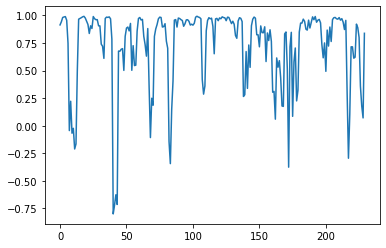

In [237]:
plt.plot(Rt_triu[0,:])

In [ ]:
dcc_model = DCC()
dcc_model.set_loss(dcc_loss_gen())
dcc_model.fit(epsilon)

# get DCC R (conditional correlation matrix)
ab = dcc_model.get_ab()
tr = epsilon
R_ls = R_gen(tr,ab)
R = np.array(R_ls)
# flatten Rt
K = R.shape[1]
Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
dcc_out = Rt_triu[0]

In [238]:
comb = list(combinations(np.arange(infile.shape[1]),2))

In [240]:
len(comb)

38781

In [262]:
def dynamic_corr_parallel(func_file, max_itr=10):
    """calculate garch-dcc"""
    sj_mat = np.load(os.path.join(func_file))
    epsilon_mat = np.empty(sj_mat.shape)
    # calculate epsilon for each roi ts
    for i, col in enumerate(sj_mat.T):
        ts_epsilon = garch_epsilon(col)
        epsilon_mat[:,i] = ts_epsilon
    # calculate dcc output
    dcc_sj = dcc_calc(eps_mat, max_itr=max_itr)
    # save correlation
    tmp = func_file.split('/')
    path_name = tmp[:-1]
    file_name = tmp[-1].split('.')[0]
    output_dir = os.path.join(*path_name)
    save_dir = os.path.join(output_dir, 'dynamic_corr')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = file_name+'_dcc.npy'
    output_file = os.path.join(save_dir, file_name)
    np.save(output_file, dcc_sj)
    print(f'dcc output saved to {output_file}')
    return dcc_sj

def dcc_calc(epsilon_mat, max_itr=10):
    """estimate DCC model given epsilon matrix of shape (t, n)"""
    epsilon = epsilon_mat.T # (n,t)
    dcc_model = DCC(max_itr=max_itr)
    dcc_model.set_loss(dcc_loss_gen())
    dcc_model.fit(epsilon)
    # get DCC R (conditional correlation matrix)
    ab = dcc_model.get_ab()
    tr = epsilon
    R_ls = R_gen(tr,ab)
    R = np.array(R_ls)
    # flatten Rt
    K = R.shape[1]
    Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
    return Rt_triu

def garch_epsilon(t1):
    """calculate GARCH(1,1) epsilon of given ts vector (t,)"""
    t1_model = GARCH(1,1)
    t1_model.set_loss(garch_loss_gen(1,1))
    t1_model.set_max_itr(1)
    t1_model.fit(t1)
    t1_sigma = t1_model.sigma(t1)
    t1_epsilon = t1/t1_sigma
    return t1_epsilon

In [248]:
eps_mat = dynamic_corr_parallel('../output/yeo/s01_rest_func.npy')

<ipython-input-99-b32ced05df60>:134: RuntimeWarning: divide by zero encountered in log
  loss += np.log(s[i] ** 2) + (r[i]/s[i])**2
<ipython-input-99-b32ced05df60>:134: RuntimeWarning: divide by zero encountered in true_divide
  loss += np.log(s[i] ** 2) + (r[i]/s[i])**2
<ipython-input-99-b32ced05df60>:134: RuntimeWarning: invalid value encountered in double_scalars
  loss += np.log(s[i] ** 2) + (r[i]/s[i])**2


In [260]:
eps_mat.shape

(230, 17)

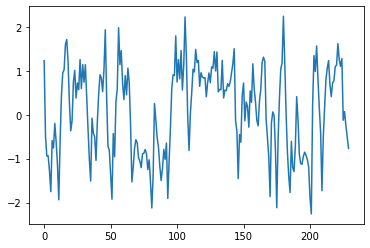

In [261]:
plt.plot(eps_mat[:,0])

In [269]:
dcc_out = dcc_calc(eps_mat, max_itr=20)

Iteration: 1. Training loss: 5.105E+07.
Iteration: 2. Training loss: 5.105E+07.
Iteration: 3. Training loss: 5.105E+07.
Iteration: 4. Training loss: 5.105E+07.
Iteration: 5. Training loss: 5.105E+07.
Iteration: 6. Training loss: 5.105E+07.
Iteration: 7. Training loss: 5.105E+07.
Iteration: 8. Training loss: 5.105E+07.
Iteration: 9. Training loss: 5.105E+07.
Iteration: 10. Training loss: 5.105E+07.
Iteration: 11. Training loss: 5.105E+07.
Iteration: 12. Training loss: 5.105E+07.
Early Stopping...


In [270]:
dcc_out.shape

(136, 230)

In [266]:
original_calc = np.load('../output/yeo/dynamic_corr/s01_rest_func_dcc.npy')

In [267]:
original_calc.shape

(136, 230)

[[1.         0.84361376]
 [0.84361376 1.        ]]


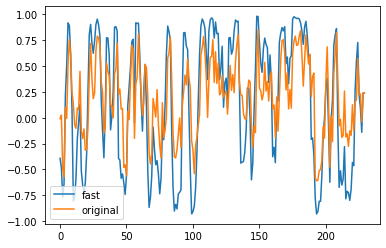

In [279]:
row = 20
plt.plot(dcc_out[row,:], label='fast')
plt.plot(original_calc[row,:], label='original')
plt.legend()
print(np.corrcoef(dcc_out[row,:], original_calc[row,:]))

In [281]:
corr_ls = []
for r in range(dcc_out.shape[0]):
    corr_ls.append(np.corrcoef(dcc_out[row,:], original_calc[row,:])[0,1])
print(np.mean(np.array(corr_ls)))

0.843613755243089


#### original

In [117]:
t1 = infile[:,0]
t1_model = GARCH(1,1)
t1_model.set_loss(garch_loss_gen(1,1))
t1_model.set_max_itr(1)
t1_model.fit(t1)
t1_sigma = t1_model.sigma(t1)
t1_epsilon = t1/t1_sigma

t2 = infile[:,1]
t2_model = GARCH(1,1)
t2_model.set_loss(garch_loss_gen(1,1))
t2_model.set_max_itr(1)
t2_model.fit(t2)
t2_sigma = t2_model.sigma(t2)
t2_epsilon = t2/t2_sigma

In [113]:
t1_epsilon[:4]

array([ 1.2316098 , -0.4924426 , -0.94035293, -0.93469299])

In [118]:
epsilon = np.array([t1_epsilon, t2_epsilon])

In [119]:
epsilon.shape

(2, 230)

In [120]:
dcc_model = DCC()
dcc_model.set_loss(dcc_loss_gen())
dcc_model.fit(epsilon)

Iteration: 1. Training loss: 3.596E+02.
Iteration: 2. Training loss: 3.596E+02.


[359.62476984466224, 359.6247697603541]

In [24]:
# %%time
# dynamic_corr(func_file)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [25]:
out = np.load('../output/yeo/dynamic_corr/s01_pain_func_dcc.npy')

In [26]:
out.shape

(136, 230)

In [28]:
17*16/2

136.0

In [29]:
import matplotlib.pyplot as plt

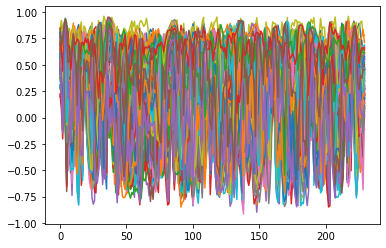

In [30]:
_=plt.plot(out.T)

In [16]:
def dynamic_corr(func_file):
    """calculate garch-dcc"""
    sj_mat = np.load(os.path.join(func_file))
    comb = list(combinations(np.arange(sj_mat.shape[1]),2))
    # calculate dcc
    dcc_ls = []
    for c in comb:
        t1 = sj_mat[:,c[0]]
        t2 = sj_mat[:,c[1]]
        dcc_out = calc_dcc(t1, t2)
        dcc_ls.append(dcc_out)
    dcc_sj = np.stack(dcc_ls)
    print(dcc_sj.shape)
    # save correlation
    tmp = func_file.split('/')
    path_name = tmp[:-1]
    file_name = tmp[-1].split('.')[0]
    output_dir = os.path.join(*path_name)
    save_dir = os.path.join(output_dir, 'dynamic_corr')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = file_name+'_dcc.npy'
    output_file = os.path.join(save_dir, file_name)
    np.save(output_file, dcc_sj)
    print(f'dcc output saved to {output_file}')
    return dcc_sj


def calc_dcc(t1, t2):
    """calcualte dcc between 2 time series"""
#     from DCC_GARCH.GARCH import GARCH, garch_loss_gen
    t1_model = GARCH(1,1)
    t1_model.set_loss(garch_loss_gen(1,1))
    t1_model.set_max_itr(1)
    t1_model.fit(t1)
    t1_sigma = t1_model.sigma(t1)
    t1_epsilon = t1/t1_sigma

    t2_model = GARCH(1,1)
    t2_model.set_loss(garch_loss_gen(1,1))
    t2_model.set_max_itr(1)
    t2_model.fit(t2)
    t2_sigma = t2_model.sigma(t2)
    t2_epsilon = t2/t2_sigma    

    epsilon = np.array([t1_epsilon, t2_epsilon])

#     from DCC_GARCH.DCC import DCC, dcc_loss_gen, R_gen
    dcc_model = DCC()
    dcc_model.set_loss(dcc_loss_gen())
    dcc_model.fit(epsilon)

    # get DCC R (conditional correlation matrix)
    ab = dcc_model.get_ab()
    tr = epsilon
    R_ls = R_gen(tr,ab)
    R = np.array(R_ls)
    # flatten Rt
    K = R.shape[1]
    Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
    dcc_out = Rt_triu[0]
    # print(dcc_out.shape)
    # import matplotlib.pyplot as plt
    # plt.plot(dcc_out)
    # plt.savefig('./test.png')
    return dcc_out